# High Impact Goal Calculation Work Book
- Identify goals scored by each team that I can classify as "High Impact"
- High Impact goals are ones scored in the first and final 2 minutes of any period OR Scored within a minute or two of a previous goal
- Create tally table of each of these goal types by team for vizualization

In [43]:
# Dependencies

# Basics
import os
import sys
import time
import sqlite3
import pandas as pd
from collections import defaultdict

# Image Handling
from PIL import Image
import matplotlib.pyplot as plt
from matplotlib import font_manager
import matplotlib.image as mpimg
import matplotlib.patches as mpatches
from matplotlib.lines import Line2D
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from matplotlib.ticker import PercentFormatter 
from matplotlib import font_manager

import seaborn as sns


## Load The Exo 2 font in case of problems with the font
font_path = 'C:/Windows/Fonts/Exo 2.tff'
locations =['../data/Exo_2'] # Font Location

font_files = font_manager.findSystemFonts(fontpaths=locations)

for file in font_files:
    font_manager.fontManager.addfont(file)




## File Paths
folder_prefix = ''

data_folder = os.path.join(folder_prefix, '..', 'data/') # Data Folder Path
temp_folder = os.path.join(folder_prefix,'..', 'TEMP/',) # Temp Folder Path
TEMP_FOLDER = temp_folder # Temp Folder Path as used in legacy code
output_folder = os.path.join(temp_folder, 'high_impact_plots/') # Output Folder Path
image_folder = os.path.join(folder_prefix, '..', 'images/') # Image Folder Path
logo_folder = os.path.join(folder_prefix, image_folder, 'logos/') # Logo Folder Path
conference_logo_folder = os.path.join(folder_prefix, logo_folder, 'conference') # Conference Logo Folder Path
export_folder = os.path.join(folder_prefix, image_folder, 'export/') # Export Folder Path
background_folder = os.path.join(folder_prefix, image_folder, 'background/') # Background Folder Path

# Other paths
school_info_path = os.path.join(data_folder, 'arena_school_info.csv') # School Info Path

## Get DB path and last game date from global settings
from config import recent_clean_db, last_game_date, tourney_bubble, frozen_four

db_path = recent_clean_db # Database Path


##################### QUICK SETTINGS #####################
### SET FIGURE SIZE
top_fig_size = (12, 12) # Top Figure Size
set_fig_size = top_fig_size # Set Figure Size as used in legacy code


### Load the Database and Helper Functions

In [44]:
## Load the database
conn = sqlite3.connect(db_path, isolation_level=None)

# convert string time to continuous time
## SQL query to fetch
def extract_goal_summary(conn):
    """
    Extracts and preprocesses the goal summary data from the database.
    """
    query = """
        WITH UniqueGoals AS (
        SELECT DISTINCT Game_ID, Team, Period, Time, PP
        FROM scoring_summary
    )
    SELECT * FROM UniqueGoals;
    """
    goal_df = pd.read_sql(query, conn)
    return goal_df

# Convert string time to continuous time
def convert_to_continuous_time(row):
    """
    Converts period-based time to a continuous format (0-65 minutes).
    """
    period_offsets = {'1st Period': 0, '2nd Period': 20, '3rd Period': 40, 'Overtime': 60}
    minutes, seconds = map(int, row['Time'].split(':'))
    offset = period_offsets.get(row['Period'], 0)
    return offset + minutes + seconds / 60.0

## Load the data
goal_data = extract_goal_summary(conn)
# Create a continuous time column
goal_data['Cont_Time'] = goal_data.apply(convert_to_continuous_time, axis=1)

## Identify Empty Net Goals (EN in the PP column) and flag in a new column
goal_data['EN'] = goal_data['PP'].apply(lambda x: 'EN' in x)

# goal_data.head()


#### Function to catagorize goal types

In [45]:

# Define the function for categorizing goal types
def goal_type_first_last(row):
    """
    Categorizes goals as first minute, last minute, or other.
    """
    # Check if the goal is in the first minute
    if (row['Cont_Time'] < 1 or  # Before the end of the first minute of the game
        (row['Cont_Time'] > 20 and row['Cont_Time'] < 21) or  # Between 20:00 and 21:00 (1st period)
        (row['Cont_Time'] > 40 and row['Cont_Time'] < 41) or  # Between 40:00 and 41:00 (2nd period)
        (row['Cont_Time'] > 60 and row['Cont_Time'] < 61)):  # Between 60:00 and 61:00 (3rd period)
        return 'First Minute'

    # Check if the goal is in the last minute of a period
    elif (row['Cont_Time'] > 19 and row['Cont_Time'] < 20 or  # Between 19:00 and 20:00 (1st period)
          (row['Cont_Time'] > 39 and row['Cont_Time'] < 40) or  # Between 39:00 and 40:00 (2nd period)
          (row['Cont_Time'] > 59 and row['Cont_Time'] < 60) or  # Between 59:00 and 60:00 (3rd period)
          (row['Cont_Time'] > 64 and row['Cont_Time'] < 65)):  # Between 64:00 and 65:00 (overtime)
        return 'Last Minute'

    # Otherwise, categorize as 'Other'
    else:
        return 'Other'

## Do the Same thing to flag the goals that happened in the first and last 2 minutes of the period
def goal_type_first2_last_2(row):
    """
    Flag the goals that happened in the first and last 2 minutes of the period
    """

    if (row['Cont_Time'] < 2 or  # Before the end of the first minute of the game
        (row['Cont_Time'] > 20 and row['Cont_Time'] < 22) or  # Between 20:00 and 21:00 (1st period)
        (row['Cont_Time'] > 40 and row['Cont_Time'] < 42) or  # Between 40:00 and 41:00 (2nd period)
        (row['Cont_Time'] > 60 and row['Cont_Time'] < 62)):  # Between 60:00 and 61:00 (3rd period)
        return 'First 2 Minutes'

    # Check if the goal is in the last 2 minutes of a period
    elif (row['Cont_Time'] > 18 and row['Cont_Time'] < 20 or  # Between 18:00 and 20:00 (1st period)
          (row['Cont_Time'] > 38 and row['Cont_Time'] < 40) or  # Between 38:00 and 40:00 (2nd period)
          (row['Cont_Time'] > 58 and row['Cont_Time'] < 60) or  # Between 58:00 and 60:00 (3rd period)
          (row['Cont_Time'] > 63 and row['Cont_Time'] < 65)):  # Between 63:00 and 65:00 (overtime)
        return 'Last 2 Minutes'
    else:
        return 'Other'


# Create a new column for the goal type
goal_data['Goal_Type'] = goal_data.apply(goal_type_first_last, axis=1)

# Create a new column to flag the goals that happened in the first and last 2 minutes of the period
goal_data['Goal_Type_2'] = goal_data.apply(goal_type_first2_last_2, axis=1)

# Check if The EN goals are in the last minute and flag them as such in new column
goal_data['EN_Last_Minute'] = (goal_data['EN'] & (goal_data['Goal_Type'] == 'Last Minute'))
# DO the same for the last 2 minutes
goal_data['EN_Last_2_Minutes'] = (goal_data['EN'] & (goal_data['Goal_Type_2'] == 'Last 2 Minutes'))

## Add a new column for Opponent name by extracting the team name of the opponent from the game_id
# Function to extract opponent based on Game_ID and Team
def extract_opponent(row):
    # Split the Game_ID to isolate team names
    teams = row['Game_ID'].split('-')[-2:]
    # Return the team that is not the current team
    return teams[1] if row['Team'] == teams[0] else teams[0]

# Add the Opponent column
goal_data['Opponent'] = goal_data.apply(extract_opponent, axis=1)

# Display the updated DataFrame to verify the changes
# goal_data.head()




### Count High Impact Goals Scored (Goals scored within a minute or 2 of another goal being scored)

In [46]:
# Sort the data by Game_ID and Cont_Time for chronological processing
goal_data_sorted = goal_data.sort_values(by=['Game_ID', 'Cont_Time']).reset_index(drop=True)

# Display the sorted data to verify
goal_data_sorted.head()

# Group data by Game_ID to analyze each game separately
grouped = goal_data_sorted.groupby('Game_ID')


# Debugging the logic and fixing the issue
# Reinitialize dictionaries to track counts
team_quick_responses = defaultdict(int)
opponent_quick_responses = defaultdict(int)

# Process each game individually again
for game_id, game_data in grouped:
    # Reset index for easier row iteration
    game_data = game_data.reset_index(drop=True)
    
    # Iterate through goals in this game
    for i in range(len(game_data)):
        current_team = game_data.loc[i, 'Team']
        current_time = game_data.loc[i, 'Cont_Time']
        
        # Compare with subsequent goals in the same game
        for j in range(i + 1, len(game_data)):
            next_team = game_data.loc[j, 'Team']
            next_time = game_data.loc[j, 'Cont_Time']
            
            # If the time difference is more than 1 minute, stop checking
            if next_time - current_time > 1:
                break
            
            # If the same team scores again within 1 minute
            if next_team == current_team:
                team_quick_responses[current_team] += 1
            
            # If the opposing team scores within 1 minute
            elif next_team != current_team:
                opponent_quick_responses[current_team] += 1

# Create the results DataFrame with updated column labels
quick_responses_df = pd.DataFrame({
    'Team': list(set(goal_data_sorted['Team'])),
    'HI_Back_to_Back': [team_quick_responses[team] for team in set(goal_data_sorted['Team'])],
    'HI_Quick_Response': [opponent_quick_responses[team] for team in set(goal_data_sorted['Team'])]
})

# Reinitialize dictionaries to track the new counts for goals within 2 minutes
team_quick_responses_2 = defaultdict(int)
opponent_quick_responses_2 = defaultdict(int)

# Process each game again for the new 2-minute interval logic
for game_id, game_data in grouped:
    # Reset index for easier row iteration
    game_data = game_data.reset_index(drop=True)
    
    # Iterate through goals in this game
    for i in range(len(game_data)):
        current_team = game_data.loc[i, 'Team']
        current_time = game_data.loc[i, 'Cont_Time']
        
        # Compare with subsequent goals in the same game
        for j in range(i + 1, len(game_data)):
            next_team = game_data.loc[j, 'Team']
            next_time = game_data.loc[j, 'Cont_Time']
            
            # If the time difference is more than 2 minutes, stop checking for 2-minute responses
            if next_time - current_time > 2:
                break
            
            # If the same team scores again within 2 minutes
            if next_team == current_team:
                team_quick_responses_2[current_team] += 1
            
            # If the opposing team scores within 2 minutes
            elif next_team != current_team:
                opponent_quick_responses_2[current_team] += 1

# Add the new columns to the results DataFrame
quick_responses_df['HI_Back_to_Back_2'] = [
    team_quick_responses_2[team] for team in set(goal_data_sorted['Team'])
]
quick_responses_df['HI_Quick_Response_2'] = [
    opponent_quick_responses_2[team] for team in set(goal_data_sorted['Team'])
]

# Display the updated results
# quick_responses_df.head()


### Count High Impact Goals Allowed (Goals scored within a minute or 2 of another goal being scored)

In [47]:
# Sort the data by Game_ID and Cont_Time for chronological processing
goal_data_sorted = goal_data.sort_values(by=['Game_ID', 'Cont_Time']).reset_index(drop=True)

# Group data by Game_ID to analyze each game separately
grouped = goal_data_sorted.groupby('Game_ID')

# Reinitialize dictionaries to track counts
opponent_quick_responses = defaultdict(int)
team_quick_responses_by_opponent = defaultdict(int)

# Process each game individually
for game_id, game_data in grouped:
    # Reset index for easier row iteration
    game_data = game_data.reset_index(drop=True)
    
    # Iterate through goals in this game
    for i in range(len(game_data)):
        current_team = game_data.loc[i, 'Team']
        opponent_team = game_data.loc[i, 'Opponent']
        current_time = game_data.loc[i, 'Cont_Time']
        
        # Compare with subsequent goals in the same game
        for j in range(i + 1, len(game_data)):
            next_team = game_data.loc[j, 'Team']
            next_time = game_data.loc[j, 'Cont_Time']
            
            # If the time difference is more than 1 minute, stop checking
            if next_time - current_time > 1:
                break
            
            # If the opponent scores within 1 minute
            if next_team == opponent_team:
                opponent_quick_responses[current_team] += 1
            
            # If the same team scores again within 1 minute
            elif next_team == current_team:
                team_quick_responses_by_opponent[opponent_team] += 1

# Create the results DataFrame with updated column labels
quick_responses_opponent_df = pd.DataFrame({
    'Team': list(set(goal_data_sorted['Team'])),
    'HI_Quick_Response_Against': [opponent_quick_responses[team] for team in set(goal_data_sorted['Team'])],
    'HI_Back_to_Back_Against': [team_quick_responses_by_opponent[team] for team in set(goal_data_sorted['Team'])]
})

# Reinitialize dictionaries for the new 2-minute interval logic
opponent_quick_responses_2 = defaultdict(int)
team_quick_responses_by_opponent_2 = defaultdict(int)

# Process each game again for the new 2-minute interval logic
for game_id, game_data in grouped:
    # Reset index for easier row iteration
    game_data = game_data.reset_index(drop=True)
    
    # Iterate through goals in this game
    for i in range(len(game_data)):
        current_team = game_data.loc[i, 'Team']
        opponent_team = game_data.loc[i, 'Opponent']
        current_time = game_data.loc[i, 'Cont_Time']
        
        # Compare with subsequent goals in the same game
        for j in range(i + 1, len(game_data)):
            next_team = game_data.loc[j, 'Team']
            next_time = game_data.loc[j, 'Cont_Time']
            
            # If the time difference is more than 2 minutes, stop checking
            if next_time - current_time > 2:
                break
            
            # If the opponent scores within 2 minutes
            if next_team == opponent_team:
                opponent_quick_responses_2[current_team] += 1
            
            # If the same team scores again within 2 minutes
            elif next_team == current_team:
                team_quick_responses_by_opponent_2[opponent_team] += 1

# Add the new columns to the results DataFrame
quick_responses_opponent_df['HI_Quick_Response_Against_2'] = [
    opponent_quick_responses_2[team] for team in set(goal_data_sorted['Team'])
]
quick_responses_opponent_df['HI_Back_to_Back_Against_2'] = [
    team_quick_responses_by_opponent_2[team] for team in set(goal_data_sorted['Team'])
]

In [48]:
# quick_responses_opponent_df

### Tally The Goal Types into a Team Table

In [49]:
def enforce_column_presence(goal_tally, columns):
    """
    Ensure that all required columns are present in the goal tally DataFrame.
    If a column is missing, add it and fill with zeros.
    """
    for col in columns:
        if col not in goal_tally.columns:
            goal_tally[col] = 0
    return goal_tally

def robust_final_tally(goal_data):
    """
    Tally the number of goals by team, ensuring all expected columns are enforced explicitly.
    """
    # Define expected columns for each group type
    expected_columns_type = ['First Minute', 'Last Minute', 'Other']
    expected_columns_type2 = ['First 2 Minutes', 'Last 2 Minutes']

    # Group and tally goals by Goal_Type
    goal_tally_type = goal_data.groupby(['Team', 'Goal_Type']).size().unstack(fill_value=0).reset_index()

    # Ensure all expected columns are present for Goal_Type
    goal_tally_type = enforce_column_presence(goal_tally_type, expected_columns_type)

    # Group and tally goals by Goal_Type_2
    goal_tally_type2 = goal_data.groupby(['Team', 'Goal_Type_2']).size().unstack(fill_value=0).reset_index()

    # Ensure all expected columns are present for Goal_Type_2
    goal_tally_type2 = enforce_column_presence(goal_tally_type2, expected_columns_type2)

    # Merge both grouped DataFrames
    goal_tally = pd.merge(goal_tally_type, goal_tally_type2, on='Team', how='outer').fillna(0)

    # Ensure all columns in the final DataFrame
    all_expected_columns = ['Team'] + expected_columns_type + expected_columns_type2
    goal_tally = enforce_column_presence(goal_tally, all_expected_columns)

    # Calculate total goals
    goal_tally['Total Goals'] = (goal_tally['First Minute'] +
                                 
                                 goal_tally['Last Minute'] +
                                 
                                 goal_tally['Other_x'])

    # Calculate percentages
    goal_tally['Pct First Minute'] = goal_tally['First Minute'] / goal_tally['Total Goals'].replace(0, 1)
    goal_tally['Pct First 2 Minutes'] = goal_tally['First 2 Minutes'] / goal_tally['Total Goals'].replace(0, 1)
    goal_tally['Pct Last Minute'] = goal_tally['Last Minute'] / goal_tally['Total Goals'].replace(0, 1)
    goal_tally['Pct Last 2 Minutes'] = goal_tally['Last 2 Minutes'] / goal_tally['Total Goals'].replace(0, 1)

    # Tally EN Last Minute and EN Last 2 Minutes
    en_last_minute_tally = goal_data[goal_data['EN_Last_Minute']].groupby('Team').size()
    en_last_2_minute_tally = goal_data[goal_data['EN_Last_2_Minutes']].groupby('Team').size()

    # Add EN tallies to the final DataFrame
    goal_tally['EN Last Minute'] = goal_tally['Team'].map(en_last_minute_tally).fillna(0).astype(int)
    goal_tally['EN Last 2 Minutes'] = goal_tally['Team'].map(en_last_2_minute_tally).fillna(0).astype(int)

    return goal_tally

# Apply the function to the data
team_goal_tally = robust_final_tally(goal_data)

### Tally The Goal Types into a Team Table (for goals allowed)

In [50]:
def robust_final_tally_by_opponent(goal_data):
    """
    Tally the number of goals against each team (opponent), ensuring all expected columns are enforced explicitly.
    """
    # Define expected columns for each group type
    expected_columns_type = ['First Minute', 'Last Minute', 'Other']
    expected_columns_type2 = ['First 2 Minutes', 'Last 2 Minutes']

    # Group and tally goals by Goal_Type using Opponent
    goal_tally_type = goal_data.groupby(['Opponent', 'Goal_Type']).size().unstack(fill_value=0).reset_index()

    # Ensure all expected columns are present for Goal_Type
    goal_tally_type = enforce_column_presence(goal_tally_type, expected_columns_type)

    # Group and tally goals by Goal_Type_2 using Opponent
    goal_tally_type2 = goal_data.groupby(['Opponent', 'Goal_Type_2']).size().unstack(fill_value=0).reset_index()

    # Ensure all expected columns are present for Goal_Type_2
    goal_tally_type2 = enforce_column_presence(goal_tally_type2, expected_columns_type2)

    # Merge both grouped DataFrames
    goal_tally = pd.merge(goal_tally_type, goal_tally_type2, on='Opponent', how='outer').fillna(0)

    # Ensure all columns in the final DataFrame
    all_expected_columns = ['Opponent'] + expected_columns_type + expected_columns_type2
    goal_tally = enforce_column_presence(goal_tally, all_expected_columns)

    # Calculate total goals scored against each opponent
    goal_tally['Total Goals Against'] = (goal_tally['First Minute'] +
                                         goal_tally['Last Minute'] +
                                         goal_tally['Other_x'])

    # Calculate percentages of goals against each opponent
    goal_tally['Pct First Minute Against'] = goal_tally['First Minute'] / goal_tally['Total Goals Against'].replace(0, 1)
    goal_tally['Pct First 2 Minutes Against'] = goal_tally['First 2 Minutes'] / goal_tally['Total Goals Against'].replace(0, 1)
    goal_tally['Pct Last Minute Against'] = goal_tally['Last Minute'] / goal_tally['Total Goals Against'].replace(0, 1)
    goal_tally['Pct Last 2 Minutes Against'] = goal_tally['Last 2 Minutes'] / goal_tally['Total Goals Against'].replace(0, 1)

    # Tally EN Last Minute and EN Last 2 Minutes using Opponent
    en_last_minute_tally = goal_data[goal_data['EN_Last_Minute']].groupby('Opponent').size()
    en_last_2_minute_tally = goal_data[goal_data['EN_Last_2_Minutes']].groupby('Opponent').size()

    # Add EN tallies to the final DataFrame
    goal_tally['EN Last Minute Against'] = goal_tally['Opponent'].map(en_last_minute_tally).fillna(0).astype(int)
    goal_tally['EN Last 2 Minutes Against'] = goal_tally['Opponent'].map(en_last_2_minute_tally).fillna(0).astype(int)

    return goal_tally

opponent_goal_tally = robust_final_tally_by_opponent(goal_data)

# add the string "_allowed" to the columns to indicate that these are goals allowed by the team
opponent_goal_tally.columns = [f'{col}_Allowed' if col != 'Opponent' else col for col in opponent_goal_tally.columns]

# Rename the Opponent column to Team for consistency
opponent_goal_tally.rename(columns={'Opponent': 'Team'}, inplace=True)

opponent_goal_tally.head()

,Team,First Minute_Allowed,Last Minute_Allowed,Other_x_Allowed,First 2 Minutes_Allowed,Last 2 Minutes_Allowed,Other_y_Allowed,Other_Allowed,Total Goals Against_Allowed,Pct First Minute Against_Allowed,Pct First 2 Minutes Against_Allowed,Pct Last Minute Against_Allowed,Pct Last 2 Minutes Against_Allowed,EN Last Minute Against_Allowed,EN Last 2 Minutes Against_Allowed
0,Air Force,9,10,93,18,23,71,0,112,0.080357,0.160714,0.089286,0.205357,3,7
1,Alaska,6,7,76,8,14,67,0,89,0.067416,0.089888,0.078652,0.157303,4,7
2,Alaska Anchorage,6,9,102,18,19,80,0,117,0.051282,0.153846,0.076923,0.162393,0,5
3,American Int'l,6,14,150,14,24,132,0,170,0.035294,0.082353,0.082353,0.141176,3,6
4,Arizona State,5,10,88,11,16,76,0,103,0.048544,0.106796,0.097087,0.155340,2,5


#### Merge the High Impact goal data with the Team Goal Tally

In [51]:
## Merge the two opponent dataframes
opponent_goal_tally = opponent_goal_tally.merge(quick_responses_opponent_df, on='Team', how='outer').fillna(0)

# check data
opponent_goal_tally.head()

,Team,First Minute_Allowed,Last Minute_Allowed,Other_x_Allowed,First 2 Minutes_Allowed,Last 2 Minutes_Allowed,Other_y_Allowed,Other_Allowed,Total Goals Against_Allowed,Pct First Minute Against_Allowed,Pct First 2 Minutes Against_Allowed,Pct Last Minute Against_Allowed,Pct Last 2 Minutes Against_Allowed,EN Last Minute Against_Allowed,EN Last 2 Minutes Against_Allowed,HI_Quick_Response_Against,HI_Back_to_Back_Against,HI_Quick_Response_Against_2,HI_Back_to_Back_Against_2
0,Air Force,9.0,10.0,93.0,18.0,23.0,71.0,0.0,112.0,0.080357,0.160714,0.089286,0.205357,3.0,7.0,1.0,5.0,6.0,11.0
1,Alaska,6.0,7.0,76.0,8.0,14.0,67.0,0.0,89.0,0.067416,0.089888,0.078652,0.157303,4.0,7.0,0.0,3.0,5.0,6.0
2,Alaska Anchorage,6.0,9.0,102.0,18.0,19.0,80.0,0.0,117.0,0.051282,0.153846,0.076923,0.162393,0.0,5.0,3.0,4.0,11.0,6.0
3,American Int'l,6.0,14.0,150.0,14.0,24.0,132.0,0.0,170.0,0.035294,0.082353,0.082353,0.141176,3.0,6.0,0.0,0.0,0.0,0.0
4,American Intl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.0,0.0,4.0,0.0


In [52]:
# Merge the High Impact Goal data with the goal tally data
team_goal_tally = pd.merge(team_goal_tally, quick_responses_df, on='Team', how='outer')

# Reorganize the table into the following order
# Team, Total Goals, First minute, Pct First Minute, First 2 Minutes, Pct First 2 Minutes, 
# Last Minute, EN Last Minute, Pct Last Minute, Last 2 Minutes, EN Last 2 Minutes, Pct Last 2 Minutes, HI Back-to-Back, 
# HI Quick Response, HI Back-to-Back 2, HI Quick Response 2

# Define the column order
column_order = ['Team', 'Total Goals', 'First Minute', 'Pct First Minute', 'First 2 Minutes', 'Pct First 2 Minutes',
                'Last Minute', 'EN Last Minute', 'Pct Last Minute', 'Last 2 Minutes', 'EN Last 2 Minutes', 'Pct Last 2 Minutes',
                'HI_Back_to_Back', 'HI_Quick_Response', 'HI_Back_to_Back_2', 'HI_Quick_Response_2']

# Reorder the columns
team_goal_tally = team_goal_tally[column_order]


# Display the final DataFrame
team_goal_tally.head()

,Team,Total Goals,First Minute,Pct First Minute,First 2 Minutes,Pct First 2 Minutes,Last Minute,EN Last Minute,Pct Last Minute,Last 2 Minutes,EN Last 2 Minutes,Pct Last 2 Minutes,HI_Back_to_Back,HI_Quick_Response,HI_Back_to_Back_2,HI_Quick_Response_2
0,Air Force,86,2,0.023256,5,0.058140,8,1,0.093023,16,1,0.186047,4,1,8,6
1,Alaska,73,3,0.041096,8,0.109589,4,1,0.054795,7,2,0.095890,2,0,4,5
2,Alaska Anchorage,75,5,0.066667,6,0.080000,4,1,0.053333,10,3,0.133333,1,3,1,11
3,American Intl,92,1,0.010870,6,0.065217,7,2,0.076087,10,2,0.108696,3,5,8,7
4,Arizona State,136,5,0.036765,13,0.095588,17,4,0.125000,22,6,0.161765,4,4,12,9


## Vizualizations

### Create school logo and color dictionary to use in plotting function

In [53]:
## Load the school info to get hex codes, logo files, and other info
school_info_df = pd.read_csv(school_info_path)


# Remove punctuation from the school names (dashes with spaces, . and ' with nothing)
school_info_df['Team'] = school_info_df['Team'].str.replace('-', ' ')
school_info_df['Team'] = school_info_df['Team'].str.replace('.', '')
school_info_df['Team'] = school_info_df['Team'].str.replace("'", '')

school_info_df['School'] = school_info_df['School'].str.replace('-', ' ')
school_info_df['School'] = school_info_df['School'].str.replace('.', '')
school_info_df['School'] = school_info_df['School'].str.replace("'", '')
# school_info_df.head() # Check the data

# # Create a color dictionary with just the primary (hex1) and secondary (hex2) colors from the school info
# Team: hex1, hex2
# Drop unused columns
school_color_df = school_info_df[['Team', 'hex1', 'hex2']]
color_mapping = school_color_df.set_index('Team').T.to_dict('list')
# color_mapping # Show dictionary
## MAY NEED TO ADD LEADING/ TRAILING zeros to the hex codes

# Create a dictionary of school logos
# Team: logo + '.png'
# Drop unused columns
school_logo_df = school_info_df[['Team', 'logo_abv']]
school_logo_df['logo_abv'] = school_logo_df['logo_abv'] + '.png'
logo_mapping = school_logo_df.set_index('Team')['logo_abv'].to_dict()
# logo_mapping # Check the dictionary




C:\Users\jbanc\AppData\Local\Temp\ipykernel_23496\1587582240.py:19: UserWarning: DataFrame columns are not unique, some columns will be omitted.
  color_mapping = school_color_df.set_index('Team').T.to_dict('list')
C:\Users\jbanc\AppData\Local\Temp\ipykernel_23496\1587582240.py:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  school_logo_df['logo_abv'] = school_logo_df['logo_abv'] + '.png'


#### Helper function for Logos and team colors

In [54]:
## Sub function to use withing plotting functions to place logos
def add_logos_to_plot(data_df, x_col, y_col, logo_mapping, logo_folder, ax, teams_in_region):
    # Plot logos for specific teams
    for team in teams_in_region:
        team_data = data_df[data_df['Team'] == team]
        if not team_data.empty:
            x = team_data[x_col].values[0]
            y = team_data[y_col].values[0]
            logo_path = os.path.join(logo_folder, logo_mapping.get(team, ""))
            if logo_path:
                try:
                    logo_img = plt.imread(logo_path)
                    imagebox = OffsetImage(logo_img, zoom=0.15)  # Adjust zoom as needed
                    ab = AnnotationBbox(imagebox, (x, y), frameon=False, xybox=(0, 0), boxcoords="offset points", pad=0)
                    ax.add_artist(ab)  # Apply the ax here as the artist is being added to ax
                except Exception as e:
                    print(f"Error adding logo for {team}: {e}")

In [55]:
## Make sure the color mapping dictionary has valid hex color codes
def clean_color_mapping(color_mapping):
    """
    Cleans and validates color codes in the color_mapping dictionary.
    Ensures all colors are valid hex codes starting with '#'.

    Parameters:
    - color_mapping (dict): A dictionary where the key is the team name and the value is a list of hex colors.

    Returns:
    - cleaned_mapping (dict): A dictionary with properly formatted hex color codes.
    """
    cleaned_mapping = {}
    for team, colors in color_mapping.items():
        cleaned_colors = []
        for color in colors:
            if isinstance(color, str):
                # Ensure it starts with '#' and is a valid hex color code
                color = color.strip()
                if not color.startswith('#'):
                    color = f'#{color}'
                if len(color) == 7 and all(c in '0123456789ABCDEFabcdef' for c in color[1:]):
                    cleaned_colors.append(color)
                else:
                    # Use a fallback color if invalid
                    cleaned_colors.append('#000000')  # Default to black for invalid colors
            else:
                cleaned_colors.append('#000000')  # Default to black for non-string values
        cleaned_mapping[team] = cleaned_colors
    return cleaned_mapping

# Clean and validate the color mapping
color_mapping = clean_color_mapping(color_mapping)

##### Check Team Logos for proper format

In [56]:
# ## Make sure the logo mapping dictionary has valid file names and the correct color format
# def convert_to_rgba(logo_mapping, logo_folder):
#     for team, filename in logo_mapping.items():
#         file_path = os.path.join(logo_folder, filename)
#         try:
#             with Image.open(file_path) as img:
#                 # Convert the image to RGBA if not already in that mode
#                 if img.mode != 'RGBA':
#                     rgba_image = img.convert('RGBA')
#                     # Save the converted image back to the folder
#                     rgba_image.save(file_path)
#                     print(f"Converted {filename} to RGBA.")
#                 else:
#                     print(f"{filename} is already RGBA.")
#         except FileNotFoundError:
#             print(f"File {filename} not found in {logo_folder}.")
#         except Exception as e:
#             print(f"An error occurred with {filename}: {e}")

# # Run the conversion function
# convert_to_rgba(logo_mapping, logo_folder)

## Create the plots

#### Figure and Font Size Settings

In [57]:
# figure_size = square_fig

#### INSTAGRAM SIZE - Portrait
dpi = 600
width, height = 1080, 1350  # in pixels
# figure_size = (width / dpi, height / dpi)  # in inches
# figure_size = (10,10)
figure_size = top_fig_size

font = "Exo 2"
size1 = 24
size2 = 20
size3 = 16
size4 = 12
size5 = 8
large_tick_label_size = 20
# Set up Font Parameters that are used in some of the legacy code
## FONT PARAMETERS

font_title_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size1}
font_label_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size2}
font_tick_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size3}
font_label_large_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': large_tick_label_size}
font_tick_large_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': large_tick_label_size}
font_tag_parm = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size1}
font_tag_parm_2 = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size1}
font_note_param = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size5}
font_tick_param_small = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size4}
font_title_param_2 = {'family': font, 'color': 'black', 'weight': 'normal', 'size': size2}


## Set the column widths for the table in the scatter plots
col_widths = [0.30, 0.225, 0.225]  # Adjust the values as needed

#### Create dictionary of team groups 

In [58]:
### In season Tourney Groups
# Create a list with all 65 D1 Teams
all_teams = list(set(goal_data['Team']))
# create logo map for all teams
all_logo_mapping = {team: logo_mapping.get(team, '') for team in all_teams}


# Four Team Group (GLI)
gli_teams = ['Michigan Tech', 'Western Michigan', 'Michigan State', 'Northern Michigan']
gli_logo_mapping = {team: logo_mapping.get(team, '') for team in gli_teams}

# Four Team Group (Beanpot)
beanpot_teams = ['Boston College', 'Boston University', 'Harvard', 'Northeastern']
beanpot_logo_mapping = {team: logo_mapping.get(team, '') for team in beanpot_teams}

# Kwick Trip Faceoff - Wis hosted Dec 28-29
kwik_trip_teams = ["Wisconsin", "Ferris State", "Connecticut", "Alaska"]
kwik_trip_logo_mapping = {team: logo_mapping.get(team, '') for team in kwik_trip_teams}

# Desert Hockey Classic - ASU hosted Jan 3-4
desert_classic_teams = ["Arizona State", "Robert Morris", "Cornell", "Massachusetts" ]
desert_classic_logo_mapping = {team: logo_mapping.get(team, '') for team in desert_classic_teams}

# Auld Lang Syne - Dec 28-29
auld_lang_teams = ["Dartmouth", "Alaska Anchorage", "Northeastern", "Providence"]
auld_lang_logo_mapping = {team: logo_mapping.get(team, '') for team in auld_lang_teams}


### Call the Appropriate Group of teams by uncommenting out the group to plot

# Groups Defined Above to Call
# conference_teams_mens
# 'Atlantic', 'Big Ten', 'CCHA', 'ECAC', 'Hockey East', 'NCHC', 'Independents'

# conference_teams_womens
# 'Atlantic', 'ECAC', 'Hockey East', 'NewHA', 'WCHA'
# 
# plot_group = 'Toledo Regional'
# plot_group = 'Allentown Regional'
# plot_group = 'Manchester Regional'
plot_group = 'Fargo Regional'
plot_group = '2025 Frozen Four'
# plot_group = 'NCAA At-Large Contenders'  # Set the group to plot
# plot_group = 'Full 64'
# plot_group = 'Big Ten'  # Set the group to plot
# plot_group = 'Atlantic'  # Set the group to plot
# plot_group = 'CCHA'  # Set the group to plot
# plot_group = 'ECAC'  # Set the group to plot
# plot_group = 'Hockey East'  # Set the group to plot
# plot_group = 'NCHC'  # Set the group to plot

# Plot The GLI Teams
# plot_group = 'GLI'  # Set the group to plot
# plot_group = 'Great Lakes Invitational'
# plot_group = 'Beanpot'  # Set the group to plot
# plot_group = 'Test BC'  # Set the group to plot/
# plot_group = 'Kwik Trip'  # Set the group to plot
# plot_group = 'Desert Classic'  # Set the group to plot
# plot_group = 'Auld Lang Syne'  # Set the group to plot
# plot_group = 'Independents'  # Set the group to plot
# plot_group = 'WCHA'  # Set the group to plot

In [59]:
########### Custom Groups ##########
#### 2025 Regional Pairings
from config import regional_toledo, regional_fargo, regional_manchester, regional_allentown

regional_toledo_logo_mapping = {team: logo_mapping.get(team, '') for team in regional_toledo}
regional_fargo_logo_mapping = {team: logo_mapping.get(team, '') for team in regional_fargo}
regional_manchester_logo_mapping = {team: logo_mapping.get(team, '') for team in regional_manchester}
regional_allentown_logo_mapping = {team: logo_mapping.get(team, '') for team in regional_allentown}
frozen_four_logo_mapping = {team: logo_mapping.get(team, '') for team in frozen_four}


In [60]:
# Define the conferences
conference_teams_mens = {
    'Atlantic': ['Air Force', "American Intl", 'Army', 'Bentley', 'Canisius', 'Holy Cross', 'Mercyhurst', 
                 'Niagara', 'RIT', 'Robert Morris', 'Sacred Heart'],
    'Big Ten': ['Michigan', 'Michigan State', 'Minnesota', 'Notre Dame', 'Ohio State', 'Penn State', 'Wisconsin'],
    'CCHA': ['Augustana', 'Bemidji State', 'Bowling Green', 'Ferris State', 'Lake Superior', 'Michigan Tech', 
             'Minnesota State', 'Northern Michigan', 'St Thomas'],
    'ECAC': ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
             'Rensselaer', 'St Lawrence', 'Union', 'Yale'],
    'Hockey East': ['Boston College', 'Boston University', 'Connecticut', 'Maine', 'Massachusetts', 'Mass Lowell',
                    'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont'],
    'NCHC': ['Arizona State', 'Colorado College', 'Denver', 'Miami', 'Minnesota Duluth', 'North Dakota', 'Omaha', 
             'St Cloud State', 'Western Michigan'],
    'Independents': ['Alaska-Anchorage', 'Alaska', 'Lindenwood', 'Long Island', 'Stonehill'],
    'GLI': gli_teams,
    'Beanpot': beanpot_teams,
    'Kwik Trip': kwik_trip_teams,
    'Desert Classic': desert_classic_teams,
    'Auld Lang Syne': auld_lang_teams,
    'Great Lakes Invitational': gli_teams,
    'Full 64': all_teams,
    'NCAA At-Large Contenders': tourney_bubble,
    'Toledo Regional': regional_toledo,
    'Fargo Regional': regional_fargo,
    'Manchester Regional': regional_manchester,
    'Allentown Regional': regional_allentown,
    '2025 Frozen Four': frozen_four,
    
}

# Load conference logos - Mens
conference_logo_mapping_mens = {
    'Atlantic': 'atlantic.png',
    'Big Ten': 'big_ten.png',
    'CCHA': 'ccha.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NCHC': 'nchc.png',
    'Independents': 'independent_scaled.png'
}

### Conference Membersip - Women's D1
w_atlantic = ['Lindenwood', 'Mercyhurst', 'Penn State', 
            'RIT', 'Robert Morris', 'Syracuse']
w_ecac = ['Brown', 'Clarkson', 'Colgate', 'Cornell', 'Dartmouth', 'Harvard', 'Princeton', 'Quinnipiac',
        'Rensselaer', 'St Lawrence', 'Union', 'Yale']
w_hockey_east = ['Boston College', 'Boston University', 'Connecticut', 'Holy Cross', 
                'Maine', 'Merrimack', 'New Hampshire', 'Northeastern', 'Providence', 'Vermont']
w_newha = ['Assumption', 'Franklin Pierce', 'Long Island', 'Post', 'Sacred Heart',
        'Saint Anselm', 'Saint Michaels', 'Stonehill']
w_wcha = ['Bemidji State', 'Minnesota', 'Minnesota Duluth', 'Minnesota State', 'Ohio State', 
            'St Cloud State', 'St Thomas', 'Wisconsin']

conference_teams_womens = {
    'Atlantic': w_atlantic,
    'ECAC': w_ecac,
    'Hockey East': w_hockey_east,
    'NewHA': w_newha,
    'WCHA': w_wcha
}
conference_logo_mapping_womens = {
    'Atlantic': 'atlantic.png',
    'ECAC': 'ecac.png',
    'Hockey East': 'hockey_east.png',
    'NewHA': 'w_newha.png',
    'WCHA': 'w_wcha.png'
}

In [61]:
# Teams to plot
# Get list from conference dictionary
teams_to_plot = conference_teams_mens[f'{plot_group}'] # Set the group to plot from the Mens Conference Teams
# teams_to_plot = conference_teams_womens[f'{plot_group}'] # Set the group to plot from the Womens Conference Teams

# Set the figure size # Set above next to font settings
# set_fig_size = (10, 10)
# Title of Group
group_title = f'{plot_group}'

#### Set Background Image
path_to_bg_image =  'main1.png' #
alpha_value = 0.1 # Set the transparency of the background image
# Load the background image
bg_img = mpimg.imread(background_folder + path_to_bg_image)
# images\background\main1.png
# bg_img = mpimg.imread('../../images/background/main1.png') # Add '.. string to the path

# Add '.. string to the path
# bg_img = rotate(bg_img, 90) # Rotate the image

#### PLOT: Last Minute and First Minute Goals_SCORED

In [62]:
## By Goal Count

def create_first_last_goal_plot_1(group_title, teams_to_plot):
    # figure_size = set_fig_size # Unness

    # Calculate average and standard deviation for First Minute Goals and Last Minute Goals
    avg_first_minute = team_goal_tally['First Minute'].mean()
    std_first_minute = team_goal_tally['First Minute'].std()
    avg_last_minute = team_goal_tally['Last Minute'].mean()
    std_last_minute = team_goal_tally['Last Minute'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize = set_fig_size)
    sns.scatterplot(data=team_goal_tally, x='First Minute', y='Last Minute', 
        hue='Team', s=100, ax=ax)
    

    # Add Trend Line
    sns.regplot(data=team_goal_tally, x='First Minute', y='Last Minute', 
        scatter=False, ax=ax)

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Subtract 2 from the x-minimum for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and Adjust y-limits if needed
    ymin, ymax = ax.get_ylim()


    # Plot the average and standard deviation lines
    plt.axhline(y=avg_last_minute, color='red', linestyle='--', label='Average Last Minute Goals')
    plt.axvline(x=avg_first_minute, color='blue', linestyle='--', label='Average First Minute Goals')
    plt.errorbar(avg_first_minute, avg_last_minute, xerr=std_first_minute, 
        yerr=std_last_minute, fmt='o', color='purple', label='Standard Deviation')    

    # Set the background image (ensure the image is adjusted tot he new x and y limits)
    ax.imshow(bg_img, extent=[new_xmin, xmax, ymin, ymax], aspect='auto', zorder=0, alpha=alpha_value)

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(team_goal_tally, 'First Minute', 'Last Minute', logo_mapping, logo_folder, ax, teams_to_plot) # Add the logos

    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    
    plt.title(f'Scoring: First and Last Minute\n{group_title}', fontdict=font_title_param)
    plt.xlabel('First Minute Goals Scored', fontdict=font_label_param)
    plt.ylabel('Last Minute Goals Scored', fontdict=font_label_param)

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_First_Last_Goals_1.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()    
    

#### Call The First/Last Minute plot

In [63]:
##Call the function
# create_first_last_goal_plot_1(group_title, teams_to_plot)

#### PLOT: Last Minute and First Minute Goals_ALLOWED

In [64]:
def create_first_last_goal_plot_1_allowed(group_title, teams_to_plot):
    # Calculate average and standard deviation for First Minute Goals Allowed and Last Minute Goals Allowed
    avg_first_minute_allowed = opponent_goal_tally['First Minute_Allowed'].mean()
    std_first_minute_allowed = opponent_goal_tally['First Minute_Allowed'].std()
    avg_last_minute_allowed = opponent_goal_tally['Last Minute_Allowed'].mean()
    std_last_minute_allowed = opponent_goal_tally['Last Minute_Allowed'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize=set_fig_size)
    sns.scatterplot(
        data=opponent_goal_tally, x='First Minute_Allowed', y='Last Minute_Allowed',
        hue='Team', s=100, ax=ax
    )

    # Add trend line
    sns.regplot(
        data=opponent_goal_tally, x='First Minute_Allowed', y='Last Minute_Allowed',
        scatter=False, ax=ax
    )

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Modify as needed for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and adjust y-limits if needed
    ymin, ymax = ax.get_ylim()

    # Plot the average and standard deviation lines
    plt.axhline(
        y=avg_last_minute_allowed, color='red', linestyle='--', label='Average Last Minute Goals Allowed'
    )
    plt.axvline(
        x=avg_first_minute_allowed, color='blue', linestyle='--', label='Average First Minute Goals Allowed'
    )
    plt.errorbar(
        avg_first_minute_allowed, avg_last_minute_allowed,
        xerr=std_first_minute_allowed, yerr=std_last_minute_allowed,
        fmt='o', color='purple', label='Standard Deviation'
    )

    # Set the background image
    ax.imshow(
        bg_img, extent=[new_xmin, xmax, ymin, ymax],
        aspect='auto', zorder=0, alpha=alpha_value
    )

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(
        opponent_goal_tally, 'First Minute_Allowed', 'Last Minute_Allowed',
        logo_mapping, logo_folder, ax, teams_to_plot
    )

    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    plt.title(f'{group_title} - First and Last Minute Goals Allowed', fontdict=font_title_param)
    plt.xlabel('First Minute Goals Allowed', fontdict=font_label_param)
    plt.ylabel('Last Minute Goals Allowed', fontdict=font_label_param)

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_First_Last_Goals_Allowed_count.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()


In [65]:
### CALL THE FUNCTION
# create_first_last_goal_plot_1_allowed(group_title, teams_to_plot)

#### PLOT: First and Last Minute Goals By Percentage

In [66]:
## By Goal Count

def create_first_last_goal_plot_1(group_title, teams_to_plot):
    # figure_size = set_fig_size # Unness

    # Calculate average and standard deviation for First Minute Goals and Last Minute Goals
    avg_first_minute = team_goal_tally['Pct First Minute'].mean()
    std_first_minute = team_goal_tally['Pct First Minute'].std()
    avg_last_minute = team_goal_tally['Pct Last Minute'].mean()
    std_last_minute = team_goal_tally['Pct Last Minute'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize = set_fig_size)
    sns.scatterplot(data=team_goal_tally, x='Pct First Minute', y='Pct Last Minute', 
        hue='Team', s=100, ax=ax)
    

    # Add Trend Line
    sns.regplot(data=team_goal_tally, x='Pct First Minute', y='Pct Last Minute', 
        scatter=False, ax=ax)

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Subtract 2 from the x-minimum for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and Adjust y-limits if needed
    ymin, ymax = ax.get_ylim()


    # Plot the average and standard deviation lines
    plt.axhline(y=avg_last_minute, color='red', linestyle='--', label='Average Pct Last Minute Goals')
    plt.axvline(x=avg_first_minute, color='blue', linestyle='--', label='Average Pct First Minute Goals')
    plt.errorbar(avg_first_minute, avg_last_minute, xerr=std_first_minute, 
        yerr=std_last_minute, fmt='o', color='purple', label='Standard Deviation')    

    # Set the background image (ensure the image is adjusted tot he new x and y limits)
    ax.imshow(bg_img, extent=[new_xmin, xmax, ymin, ymax], aspect='auto', zorder=0, alpha=alpha_value)

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(team_goal_tally, 'Pct First Minute', 'Pct Last Minute', logo_mapping, logo_folder, ax, teams_to_plot) # Add the logos

    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    plt.title(f'Scoring: First and Last Minute (% of Total Goals)\n{group_title}', fontdict=font_title_param)
    # plt.title(f'{group_title} - First and Last Minute Goals\nBy Percentage of Total Goals', fontdict=font_title_param)
    plt.xlabel("First Minute Goals", fontdict=font_label_param)
    plt.ylabel('Last Minute Goals', fontdict=font_label_param)

    # Adjust the axis tick labels to show percentages
    ax.xaxis.set_major_formatter(PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_Pct_First_Last_Goals_1min_percent.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()    
    

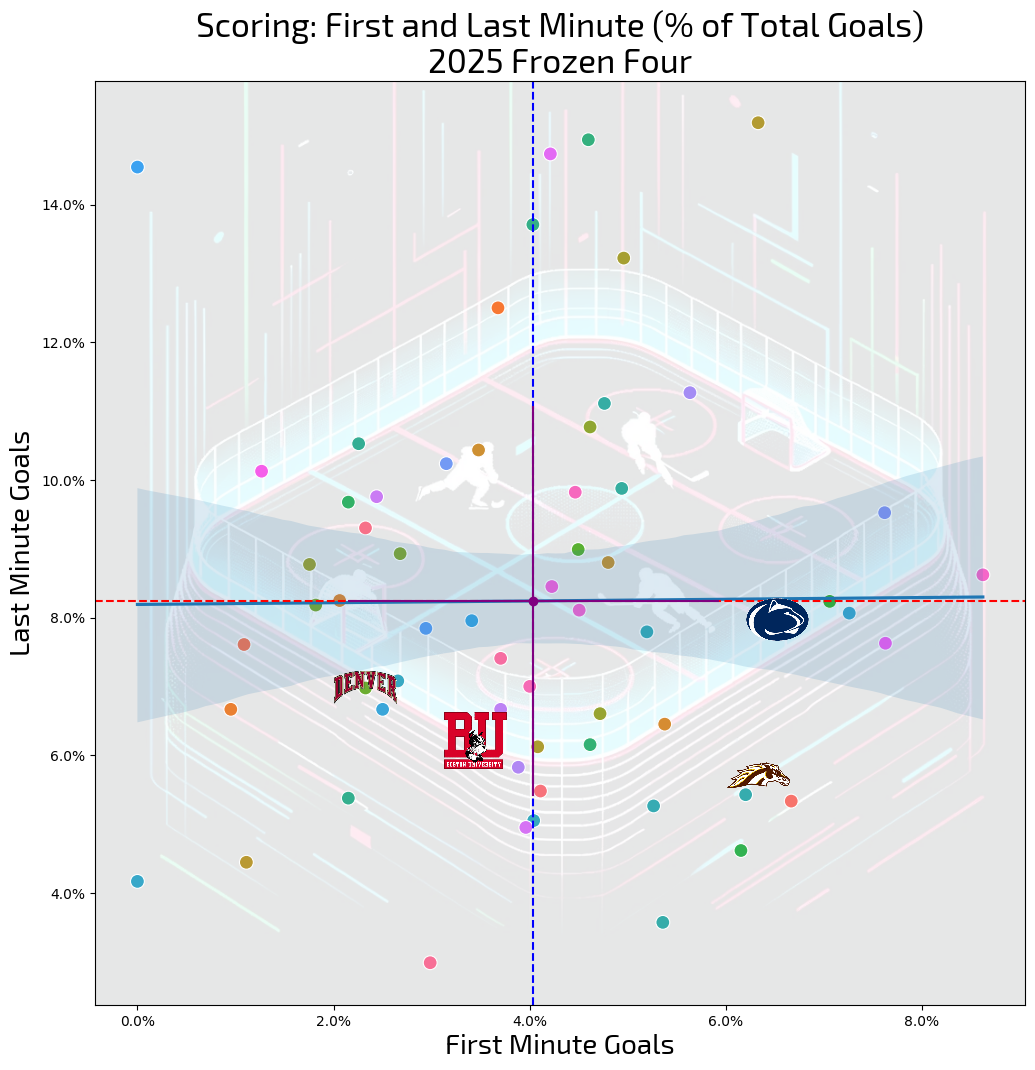

In [67]:
## Call the function
create_first_last_goal_plot_1(group_title, teams_to_plot)

#### PLOT: Last 2 Minute and First 2 Minute Goals SCORRED

In [68]:
## By Goal Count

def create_first_last_goal_plot_2(group_title, teams_to_plot):
    # figure_size = set_fig_size # Unness

    # Calculate average and standard deviation for First Minute Goals and Last Minute Goals
    avg_first_minute = team_goal_tally['First 2 Minutes'].mean()
    std_first_minute = team_goal_tally['First 2 Minutes'].std()
    avg_last_minute = team_goal_tally['Last 2 Minutes'].mean()
    std_last_minute = team_goal_tally['Last 2 Minutes'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize = set_fig_size)
    sns.scatterplot(data=team_goal_tally, x='First 2 Minutes', y='Last 2 Minutes', 
        hue='Team', s=100, ax=ax)
    

    # Add Trend Line
    sns.regplot(data=team_goal_tally, x='First 2 Minutes', y='Last 2 Minutes', 
        scatter=False, ax=ax)

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Subtract 2 from the x-minimum for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and Adjust y-limits if needed
    ymin, ymax = ax.get_ylim()


    # Plot the average and standard deviation lines
    plt.axhline(y=avg_last_minute, color='red', linestyle='--', label='Average Last Minute Goals')
    plt.axvline(x=avg_first_minute, color='blue', linestyle='--', label='Average First Minute Goals')
    plt.errorbar(avg_first_minute, avg_last_minute, xerr=std_first_minute, 
        yerr=std_last_minute, fmt='o', color='purple', label='Standard Deviation')    

    # Set the background image (ensure the image is adjusted tot he new x and y limits)
    ax.imshow(bg_img, extent=[new_xmin, xmax, ymin, ymax], aspect='auto', zorder=0, alpha=alpha_value)

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(team_goal_tally, 'First 2 Minutes', 'Last 2 Minutes', logo_mapping, logo_folder, ax, teams_to_plot) # Add the logos

    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    plt.title(f'{group_title} - Goals Scored in First and Last 2 Minutes', fontdict=font_title_param)
    plt.xlabel('First 2 Minute Goals', fontdict=font_label_param)
    plt.ylabel('Last 2 Minute Goals', fontdict=font_label_param)

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_First_Last_Goals_2min_count.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()    
    

In [69]:
## Call the function
# create_first_last_goal_plot_2(group_title, teams_to_plot)

#### PLOT: Last 2 Minute and First 2 Minute Goals ALLOWED

In [70]:
def create_first_last_goal_plot_2_allowed(group_title, teams_to_plot):
    # Calculate average and standard deviation for goals allowed in the first and last 2 minutes
    avg_first_2_minutes_allowed = opponent_goal_tally['First 2 Minutes_Allowed'].mean()
    std_first_2_minutes_allowed = opponent_goal_tally['First 2 Minutes_Allowed'].std()
    avg_last_2_minutes_allowed = opponent_goal_tally['Last 2 Minutes_Allowed'].mean()
    std_last_2_minutes_allowed = opponent_goal_tally['Last 2 Minutes_Allowed'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize=set_fig_size)
    sns.scatterplot(
        data=opponent_goal_tally, x='First 2 Minutes_Allowed', y='Last 2 Minutes_Allowed',
        hue='Team', s=100, ax=ax
    )

    # Add trend line
    sns.regplot(
        data=opponent_goal_tally, x='First 2 Minutes_Allowed', y='Last 2 Minutes_Allowed',
        scatter=False, ax=ax
    )

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Modify as needed for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and adjust y-limits if needed
    ymin, ymax = ax.get_ylim()

    # Plot the average and standard deviation lines
    plt.axhline(
        y=avg_last_2_minutes_allowed, color='red', linestyle='--', label='Average Last 2 Minutes Goals Allowed'
    )
    plt.axvline(
        x=avg_first_2_minutes_allowed, color='blue', linestyle='--', label='Average First 2 Minutes Goals Allowed'
    )
    plt.errorbar(
        avg_first_2_minutes_allowed, avg_last_2_minutes_allowed,
        xerr=std_first_2_minutes_allowed, yerr=std_last_2_minutes_allowed,
        fmt='o', color='purple', label='Standard Deviation'
    )

    # Set the background image
    ax.imshow(
        bg_img, extent=[new_xmin, xmax, ymin, ymax],
        aspect='auto', zorder=0, alpha=alpha_value
    )

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(
        opponent_goal_tally, 'First 2 Minutes_Allowed', 'Last 2 Minutes_Allowed',
        logo_mapping, logo_folder, ax, teams_to_plot
    )

    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    plt.title(f'Goals Allowed in First and Last 2 Minutes\n{group_title}', fontdict=font_title_param_2)
    plt.xlabel('First 2 Minute Goals Allowed', fontdict=font_label_param)
    plt.ylabel('Last 2 Minute Goals Allowed', fontdict=font_label_param)

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_First_Last_Goals_Allowed_2min_count.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()


In [71]:
### CALL THE FUNCTION
# create_first_last_goal_plot_2_allowed(group_title, teams_to_plot)

### PLOT: Scored first and last 2 minutes by percentage

In [72]:
## By Goal Count

def create_first_last_goal_plot_percent_2(group_title, teams_to_plot):
    # figure_size = set_fig_size # Unness

    # Calculate average and standard deviation for First Minute Goals and Last Minute Goals
    avg_first_minute = team_goal_tally['Pct First 2 Minutes'].mean()
    std_first_minute = team_goal_tally['Pct First 2 Minutes'].std()
    avg_last_minute = team_goal_tally['Pct Last 2 Minutes'].mean()
    std_last_minute = team_goal_tally['Pct Last 2 Minutes'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize = set_fig_size)
    sns.scatterplot(data=team_goal_tally, x='Pct First 2 Minutes', y='Pct Last 2 Minutes', 
        hue='Team', s=100, ax=ax)
    

    # Add Trend Line
    sns.regplot(data=team_goal_tally, x='Pct First 2 Minutes', y='Pct Last 2 Minutes', 
        scatter=False, ax=ax)

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Subtract 2 from the x-minimum for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and Adjust y-limits if needed
    ymin, ymax = ax.get_ylim()


    # Plot the average and standard deviation lines
    plt.axhline(y=avg_last_minute, color='red', linestyle='--', label='Average Pct Last Minute Goals')
    plt.axvline(x=avg_first_minute, color='blue', linestyle='--', label='Average Pct First Minute Goals')
    plt.errorbar(avg_first_minute, avg_last_minute, xerr=std_first_minute, 
        yerr=std_last_minute, fmt='o', color='purple', label='Standard Deviation')    

    # Set the background image (ensure the image is adjusted tot he new x and y limits)
    ax.imshow(bg_img, extent=[new_xmin, xmax, ymin, ymax], aspect='auto', zorder=0, alpha=alpha_value)

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(team_goal_tally, 'Pct First 2 Minutes', 'Pct Last 2 Minutes', logo_mapping, logo_folder, ax, teams_to_plot) # Add the logos

    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    plt.title(f'Scoring: First and Last 2 Minutes (% of Total Goals)\n{group_title}', fontdict=font_title_param)
    plt.xlabel('Goals Scored: First 2 Minutes', fontdict=font_label_param)
    plt.ylabel('Goals Scored: Last 2 Minutes', fontdict=font_label_param)

    # Adjust the axis tick labels to show percentages
    ax.xaxis.set_major_formatter(PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_Pct_First_Last_Goals_2min_percentage.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()    
    

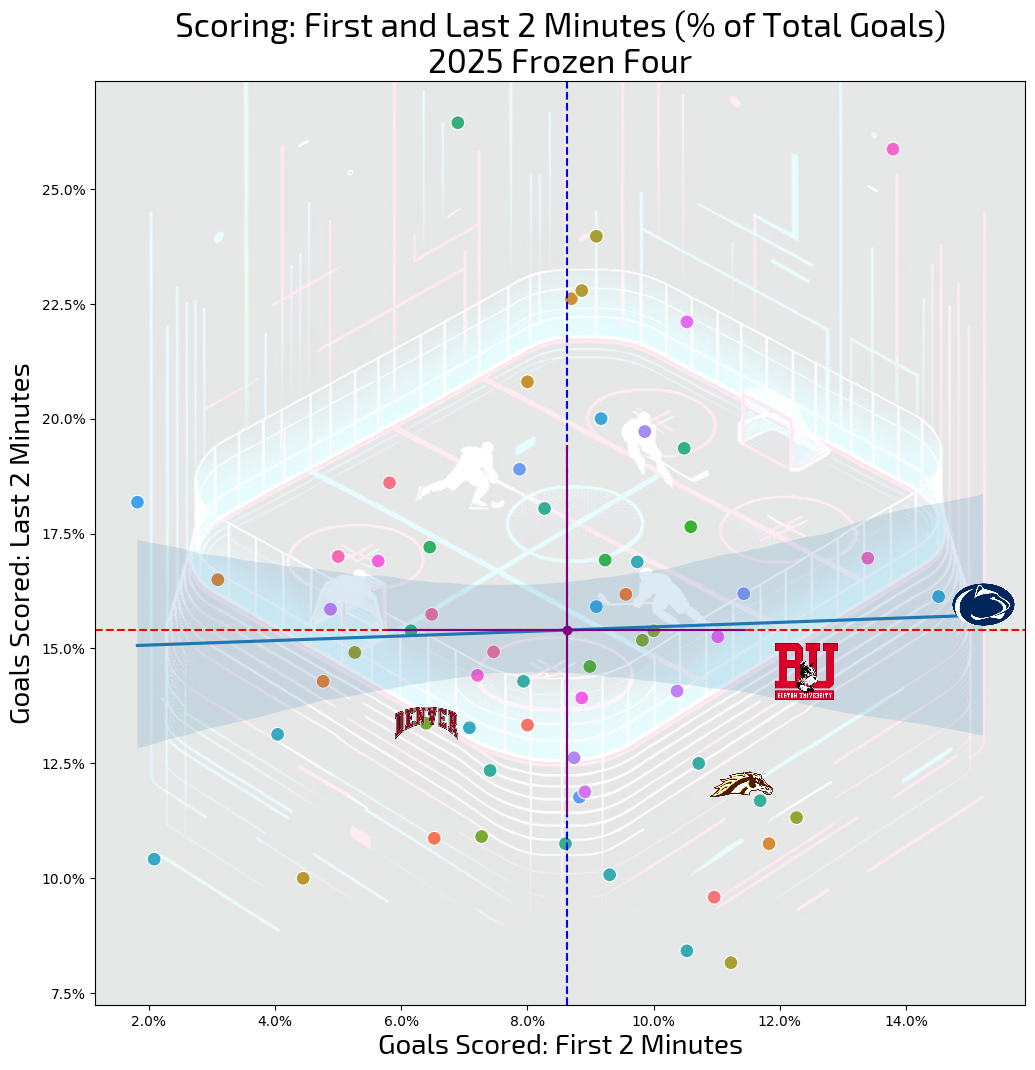

In [73]:
## Call the function
create_first_last_goal_plot_percent_2(group_title, teams_to_plot)

### PLOT: ALLOWED first and last 2 minutes by percentage

In [74]:
def create_first_last_goal_plot_percent_2_allowed(group_title, teams_to_plot):
    # Calculate average and standard deviation for percentages of goals allowed in the first and last 2 minutes
    avg_pct_first_2_minutes_allowed = opponent_goal_tally['Pct First 2 Minutes Against_Allowed'].mean()
    std_pct_first_2_minutes_allowed = opponent_goal_tally['Pct First 2 Minutes Against_Allowed'].std()
    avg_pct_last_2_minutes_allowed = opponent_goal_tally['Pct Last 2 Minutes Against_Allowed'].mean()
    std_pct_last_2_minutes_allowed = opponent_goal_tally['Pct Last 2 Minutes Against_Allowed'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize=set_fig_size)
    sns.scatterplot(
        data=opponent_goal_tally, x='Pct First 2 Minutes Against_Allowed', y='Pct Last 2 Minutes Against_Allowed',
        hue='Team', s=100, ax=ax
    )

    # Add trend line
    sns.regplot(
        data=opponent_goal_tally, x='Pct First 2 Minutes Against_Allowed', y='Pct Last 2 Minutes Against_Allowed',
        scatter=False, ax=ax
    )

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Modify as needed for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and adjust y-limits if needed
    ymin, ymax = ax.get_ylim()

    # Plot the average and standard deviation lines
    plt.axhline(
        y=avg_pct_last_2_minutes_allowed, color='red', linestyle='--', label='Average Pct Last 2 Minute Goals Allowed'
    )
    plt.axvline(
        x=avg_pct_first_2_minutes_allowed, color='blue', linestyle='--', label='Average Pct First 2 Minute Goals Allowed'
    )
    plt.errorbar(
        avg_pct_first_2_minutes_allowed, avg_pct_last_2_minutes_allowed,
        xerr=std_pct_first_2_minutes_allowed, yerr=std_pct_last_2_minutes_allowed,
        fmt='o', color='purple', label='Standard Deviation'
    )

    # Set the background image
    ax.imshow(
        bg_img, extent=[new_xmin, xmax, ymin, ymax],
        aspect='auto', zorder=0, alpha=alpha_value
    )

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(
        opponent_goal_tally, 'Pct First 2 Minutes Against_Allowed', 'Pct Last 2 Minutes Against_Allowed',
        logo_mapping, logo_folder, ax, teams_to_plot
    )

    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    # plt.title(f'Scoring: First and Last 2 Minutes (% of Total Goals)\n{group_title}', fontdict=font_title_param)
    plt.title(f'Goals Allowed First and Last 2 Minutes (% of Total Goals)\n{group_title}', fontdict=font_title_param)
    plt.xlabel('Goals Allowed - First 2 Minutes', fontdict=font_label_param)
    plt.ylabel('Goals Allowed - Last 2 Minutes', fontdict=font_label_param)
    
    # Adjust the axis tick labels to show percentages
    ax.xaxis.set_major_formatter(PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))
    
    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_Pct_First_Last_Goals_Allowed_2_percentage.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()


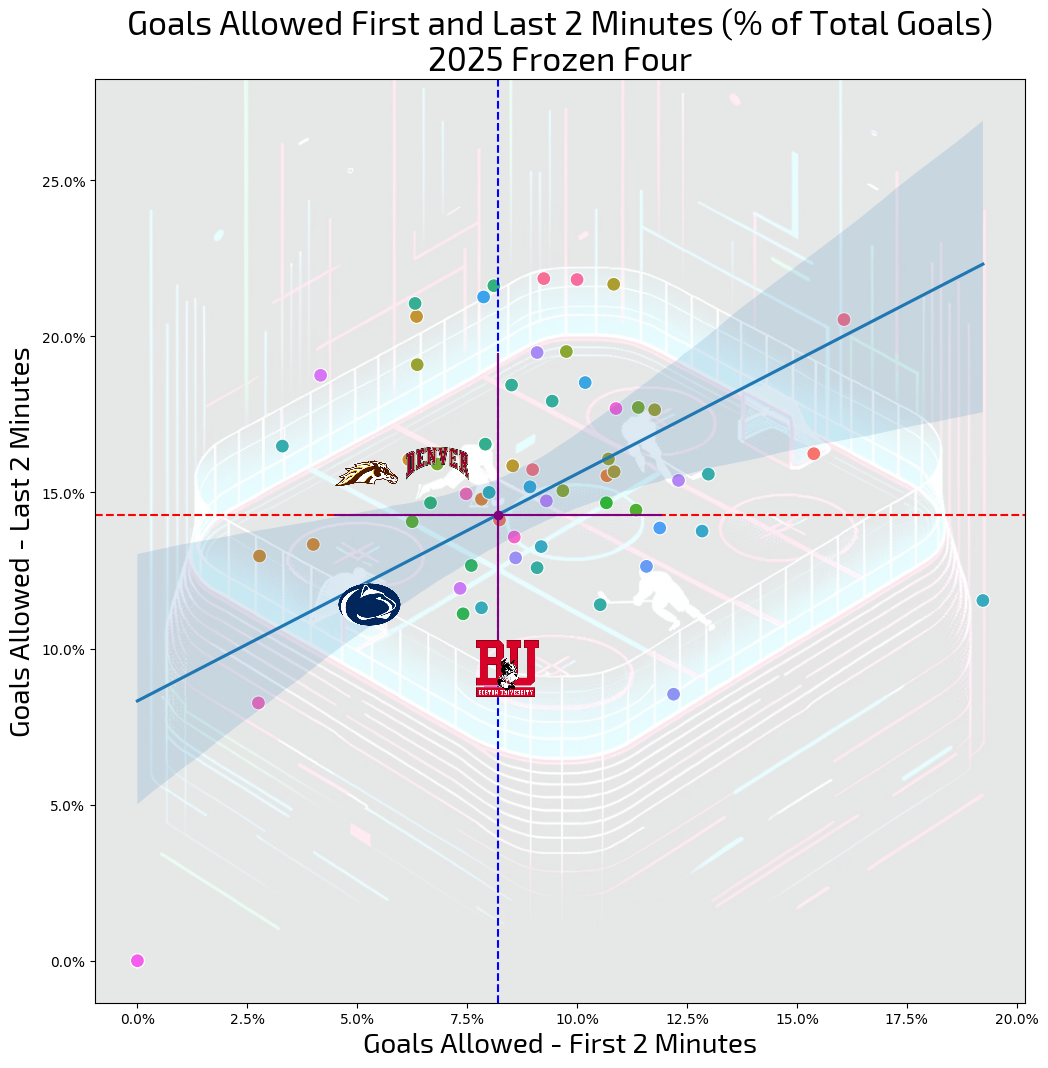

In [75]:
## CALL THE FUNCTION
create_first_last_goal_plot_percent_2_allowed(group_title, teams_to_plot)

### PLOT: GOALS ALLOWED first and last minute by percentage

In [76]:
opponent_goal_tally

,Team,First Minute_Allowed,Last Minute_Allowed,Other_x_Allowed,First 2 Minutes_Allowed,Last 2 Minutes_Allowed,Other_y_Allowed,Other_Allowed,Total Goals Against_Allowed,Pct First Minute Against_Allowed,Pct First 2 Minutes Against_Allowed,Pct Last Minute Against_Allowed,Pct Last 2 Minutes Against_Allowed,EN Last Minute Against_Allowed,EN Last 2 Minutes Against_Allowed,HI_Quick_Response_Against,HI_Back_to_Back_Against,HI_Quick_Response_Against_2,HI_Back_to_Back_Against_2
0,Air Force,9.0,10.0,93.0,18.0,23.0,71.0,0.0,112.0,0.080357,0.160714,0.089286,0.205357,3.0,7.0,1.0,5.0,6.0,11.0
1,Alaska,6.0,7.0,76.0,8.0,14.0,67.0,0.0,89.0,0.067416,0.089888,0.078652,0.157303,4.0,7.0,0.0,3.0,5.0,6.0
2,Alaska Anchorage,6.0,9.0,102.0,18.0,19.0,80.0,0.0,117.0,0.051282,0.153846,0.076923,0.162393,0.0,5.0,3.0,4.0,11.0,6.0
3,American Int'l,6.0,14.0,150.0,14.0,24.0,132.0,0.0,170.0,0.035294,0.082353,0.082353,0.141176,3.0,6.0,0.0,0.0,0.0,0.0
4,American Intl,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,4.0,0.0,4.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,Union,0.0,5.0,104.0,3.0,9.0,97.0,0.0,109.0,0.000000,0.027523,0.045872,0.082569,0.0,0.0,4.0,1.0,10.0,6.0
65,Vermont,2.0,13.0,92.0,8.0,16.0,83.0,0.0,107.0,0.018692,0.074766,0.121495,0.149533,2.0,4.0,3.0,2.0,11.0,8.0
66,Western Michigan,2.0,4.0,71.0,4.0,12.0,61.0,0.0,77.0,0.025974,0.051948,0.051948,0.155844,1.0,1.0,3.0,1.0,7.0,4.0
67,Wisconsin,6.0,14.0,90.0,11.0,24.0,75.0,0.0,110.0,0.054545,0.100000,0.127273,0.218182,3.0,4.0,3.0,2.0,8.0,3.0


In [77]:
def create_first_last_goal_plot_percent_allowed(group_title, teams_to_plot):
    # Calculate average and standard deviation for percentages of goals allowed in the first and last  minute
    avg_pct_first_minute_allowed = opponent_goal_tally['Pct First Minute Against_Allowed'].mean()
    std_pct_first_minute_allowed = opponent_goal_tally['Pct First Minute Against_Allowed'].std()
    avg_pct_last_minute_allowed = opponent_goal_tally['Pct Last Minute Against_Allowed'].mean()
    std_pct_last_minute_allowed = opponent_goal_tally['Pct Last Minute Against_Allowed'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize=set_fig_size)
    sns.scatterplot(
        data=opponent_goal_tally, x='Pct First Minute Against_Allowed', y='Pct Last Minute Against_Allowed',
        hue='Team', s=100, ax=ax
    )
    # Add trend line
    sns.regplot(
        data=opponent_goal_tally, x='Pct First Minute Against_Allowed', y='Pct Last Minute Against_Allowed',
        scatter=False, ax=ax
    )
    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()

    new_xmin = xmin  # Modify as needed for additional padding
    ax.set_xlim(new_xmin, xmax)
    # Get and adjust y-limits if needed
    ymin, ymax = ax.get_ylim()

    # Plot the average and standard deviation lines
    plt.axhline(
        y=avg_pct_last_minute_allowed, color='red', linestyle='--', label='Average Pct Last Minute Goals Allowed'
    )
    plt.axvline(
        x=avg_pct_first_minute_allowed, color='blue', linestyle='--', label='Average Pct First Minute Goals Allowed'
    )

    plt.errorbar(
        avg_pct_first_minute_allowed, avg_pct_last_minute_allowed,
        xerr=std_pct_first_minute_allowed, yerr=std_pct_last_minute_allowed,
        fmt='o', color='purple', label='Standard Deviation'
    )

    # Set the background image
    ax.imshow(
        bg_img, extent=[new_xmin, xmax, ymin, ymax],
        aspect='auto', zorder=0, alpha=alpha_value
    )

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(
        opponent_goal_tally, 'Pct First Minute Against_Allowed', 'Pct Last Minute Against_Allowed',
        logo_mapping, logo_folder, ax, teams_to_plot
    )

    # Remove the legend from the plot
    ax.get_legend().remove()
    # Add title and axis labels
    plt.title(f'Goals Allowed First and Last Minute (% of Total Goals)\n{group_title}', fontdict=font_title_param)
    plt.xlabel('Goals Allowed - First Minute', fontdict=font_label_param)
    plt.ylabel('Goals Allowed - Last Minute', fontdict=font_label_param)

    # Adjust the axis tick labels to show percentages
    ax.xaxis.set_major_formatter(PercentFormatter(1.0))
    ax.yaxis.set_major_formatter(PercentFormatter(1.0))

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_Pct_First_Last_Goals_Allowed_1min_percentage.png')
    plt.savefig(plot_path, bbox_inches='tight')
    # Show the plot
    plt.show()
    

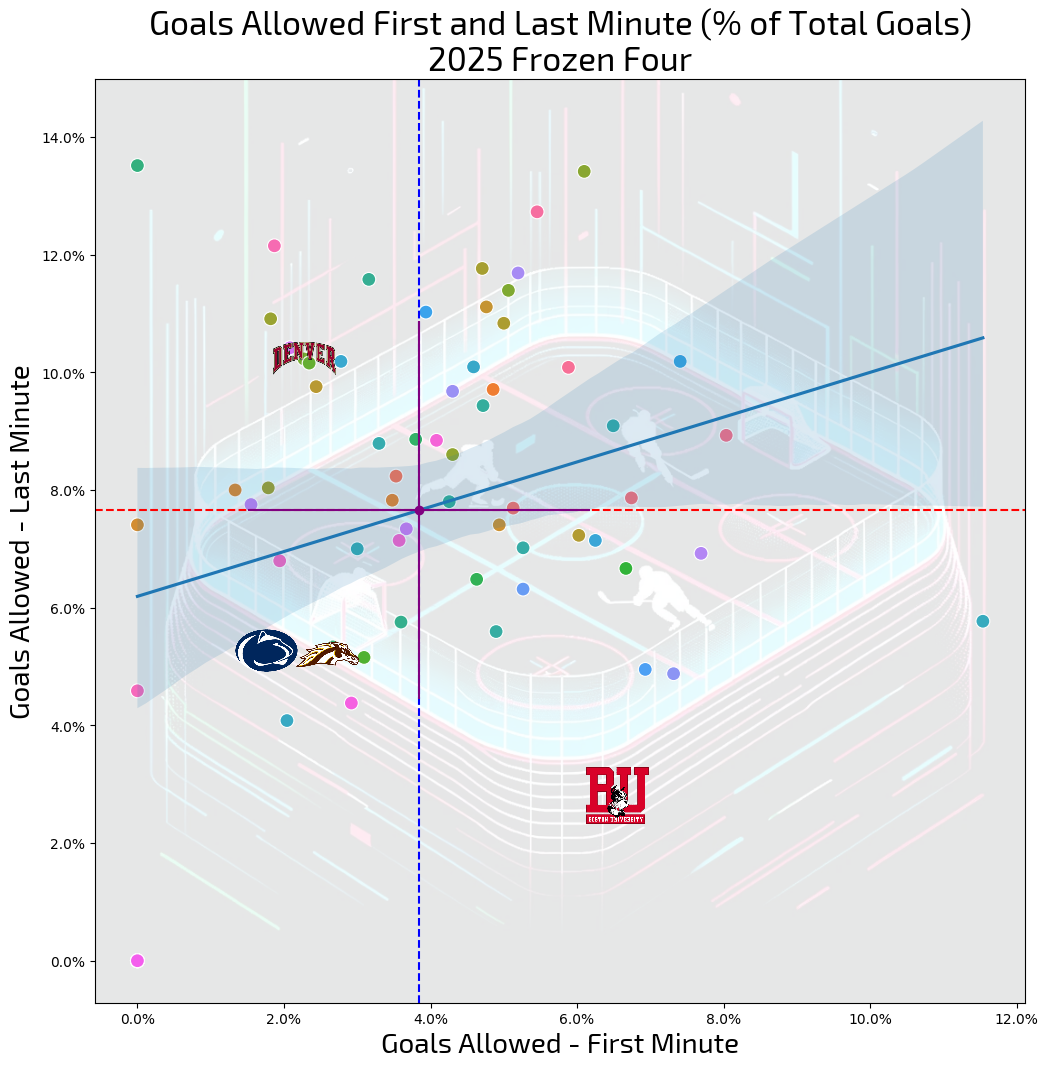

In [78]:
## Call the function
create_first_last_goal_plot_percent_allowed(group_title, teams_to_plot)

#### PLOT: High Impact Goals SCORED

In [79]:
## By Goal Count

def create_high_impact_plot_1(group_title, teams_to_plot):
    # figure_size = set_fig_size # Unness

    # Calculate average and standard deviation for First Minute Goals and Last Minute Goals
    avg_first_minute = team_goal_tally['HI_Back_to_Back'].mean()
    std_first_minute = team_goal_tally['HI_Back_to_Back'].std()
    avg_last_minute = team_goal_tally['HI_Quick_Response'].mean()
    std_last_minute = team_goal_tally['HI_Quick_Response'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize = set_fig_size)
    sns.scatterplot(data=team_goal_tally, x='HI_Quick_Response', y='HI_Back_to_Back', 
        hue='Team', s=100, ax=ax)
    

    # Add Trend Line
    sns.regplot(data=team_goal_tally, x='HI_Quick_Response', y='HI_Back_to_Back', 
        scatter=False, ax=ax)

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Subtract 2 from the x-minimum for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and Adjust y-limits if needed
    ymin, ymax = ax.get_ylim()


    # Plot the average and standard deviation lines
    plt.axhline(y=avg_last_minute, color='red', linestyle='--', label='Back to Back Goals')
    plt.axvline(x=avg_first_minute, color='blue', linestyle='--', label='Quick Response Goals')
    plt.errorbar(avg_first_minute, avg_last_minute, xerr=std_first_minute, 
        yerr=std_last_minute, fmt='o', color='purple', label='Standard Deviation')    

    # Set the background image (ensure the image is adjusted tot he new x and y limits)
    ax.imshow(bg_img, extent=[new_xmin, xmax, ymin, ymax], aspect='auto', zorder=0, alpha=alpha_value)

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(team_goal_tally, 'HI_Quick_Response', 'HI_Back_to_Back', logo_mapping, logo_folder, ax, teams_to_plot) # Add the logos

    
    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    plt.title(f'{group_title} - High Impact Goals Scored(1 Minute Window)', fontdict=font_title_param)
    plt.ylabel('Quick Back To Back Goals Scored', fontdict=font_label_param)
    plt.xlabel('Quick Response Goals Scored', fontdict=font_label_param)

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_High_Impact_1min_count.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()    
    

In [80]:
# Call the function
# create_high_impact_plot_1(group_title, teams_to_plot)

#### PLOT: High Impact (2 minute) Goals

In [81]:
## By Goal Count

def create_high_impact_plot_2(group_title, teams_to_plot):
    # figure_size = set_fig_size # Unness

    # Calculate average and standard deviation for First Minute Goals and Last Minute Goals
    avg_first_minute = team_goal_tally['HI_Back_to_Back_2'].mean()
    std_first_minute = team_goal_tally['HI_Back_to_Back_2'].std()
    avg_last_minute = team_goal_tally['HI_Quick_Response_2'].mean()
    std_last_minute = team_goal_tally['HI_Quick_Response_2'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize = set_fig_size)
    sns.scatterplot(data=team_goal_tally, x='HI_Quick_Response_2', y='HI_Back_to_Back_2', 
        hue='Team', s=100, ax=ax)
    

    # Add Trend Line
    sns.regplot(data=team_goal_tally, x='HI_Quick_Response_2', y='HI_Back_to_Back_2', 
        scatter=False, ax=ax)

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Subtract 2 from the x-minimum for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and Adjust y-limits if needed
    ymin, ymax = ax.get_ylim()


    # Plot the average and standard deviation lines
    plt.axhline(y=avg_last_minute, color='red', linestyle='--', label='Back to Back Goals')
    plt.axvline(x=avg_first_minute, color='blue', linestyle='--', label='Quick Response Goals')
    plt.errorbar(avg_first_minute, avg_last_minute, xerr=std_first_minute, 
        yerr=std_last_minute, fmt='o', color='purple', label='Standard Deviation')    

    # Set the background image (ensure the image is adjusted tot he new x and y limits)
    ax.imshow(bg_img, extent=[new_xmin, xmax, ymin, ymax], aspect='auto', zorder=0, alpha=alpha_value)

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(team_goal_tally, 'HI_Quick_Response_2', 'HI_Back_to_Back_2', logo_mapping, logo_folder, ax, teams_to_plot) # Add the logos

    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    plt.title(f'{group_title} - High Impact Goals Scored (2 Minute Limit)', fontdict=font_title_param)
    plt.ylabel('Quick Back To Back Goals Scored', fontdict=font_label_param)
    plt.xlabel('Quick Response Goals Scored', fontdict=font_label_param)

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_High_Impact_2min_count.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()    
    

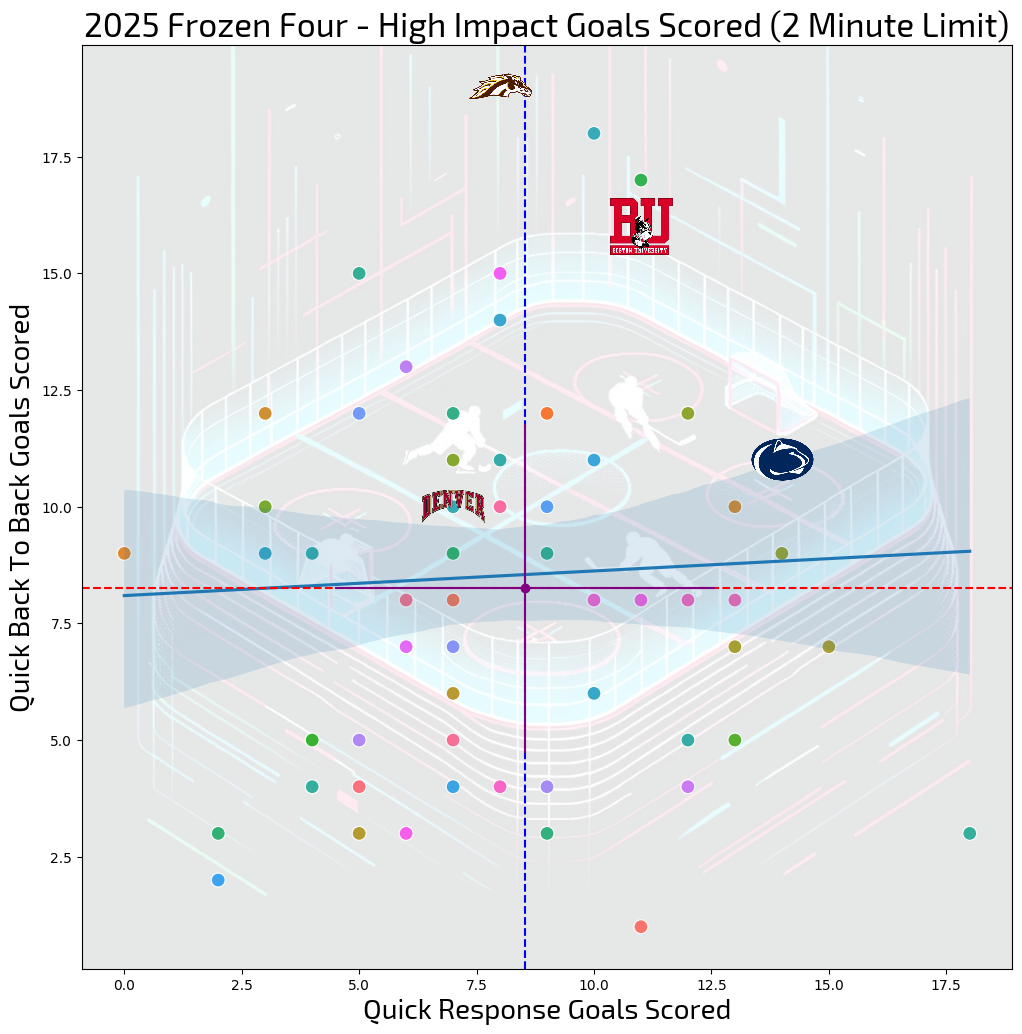

In [82]:
# Call the function
create_high_impact_plot_2(group_title, teams_to_plot)

### PLOT: High Impact ALLOWED (2 Minute Limit)

In [83]:
def create_high_impact_plot_2_allowed(group_title, teams_to_plot):
    # Calculate average and standard deviation for high impact goals allowed
    avg_back_to_back_allowed = opponent_goal_tally['HI_Back_to_Back_Against_2'].mean()
    std_back_to_back_allowed = opponent_goal_tally['HI_Back_to_Back_Against_2'].std()
    avg_quick_response_allowed = opponent_goal_tally['HI_Quick_Response_Against_2'].mean()
    std_quick_response_allowed = opponent_goal_tally['HI_Quick_Response_Against_2'].std()

    # Create the base scatter plot with all teams
    fig, ax = plt.subplots(figsize=set_fig_size)
    sns.scatterplot(
        data=opponent_goal_tally, x='HI_Quick_Response_Against_2', y='HI_Back_to_Back_Against_2',
        hue='Team', s=100, ax=ax
    )

    # Add trend line
    sns.regplot(
        data=opponent_goal_tally, x='HI_Quick_Response_Against_2', y='HI_Back_to_Back_Against_2',
        scatter=False, ax=ax
    )

    # Adjust x-axis to add padding on the left
    xmin, xmax = ax.get_xlim()
    new_xmin = xmin  # Modify as needed for additional padding
    ax.set_xlim(new_xmin, xmax)

    # Get and adjust y-limits if needed
    ymin, ymax = ax.get_ylim()

    # Plot the average and standard deviation lines
    plt.axhline(
        y=avg_back_to_back_allowed, color='red', linestyle='--', label='Average Back-to-Back Goals Allowed'
    )
    plt.axvline(
        x=avg_quick_response_allowed, color='blue', linestyle='--', label='Average Quick Response Goals Allowed'
    )
    plt.errorbar(
        avg_quick_response_allowed, avg_back_to_back_allowed,
        xerr=std_quick_response_allowed, yerr=std_back_to_back_allowed,
        fmt='o', color='purple', label='Standard Deviation'
    )

    # Set the background image
    ax.imshow(
        bg_img, extent=[new_xmin, xmax, ymin, ymax],
        aspect='auto', zorder=0, alpha=alpha_value
    )

    # Add logos for specific teams (the teams_to_plot list)
    add_logos_to_plot(
        opponent_goal_tally, 'HI_Quick_Response_Against_2', 'HI_Back_to_Back_Against_2',
        logo_mapping, logo_folder, ax, teams_to_plot
    )

    # Remove the legend from the plot
    ax.get_legend().remove()

    # Add title and axis labels
    plt.title(f'{group_title} - High Impact Goals Allowed (2 Minute Limit)', fontdict=font_title_param)
    plt.ylabel('Quick Back-to-Back Goals Allowed', fontdict=font_label_param)
    plt.xlabel('Quick Response Goals Allowed', fontdict=font_label_param)

    # Save plot to the temp output folder
    plot_path = os.path.join(output_folder, f'{group_title}_High_Impact_Allowed_2_count.png')
    plt.savefig(plot_path, bbox_inches='tight')

    # Show the plot
    plt.show()


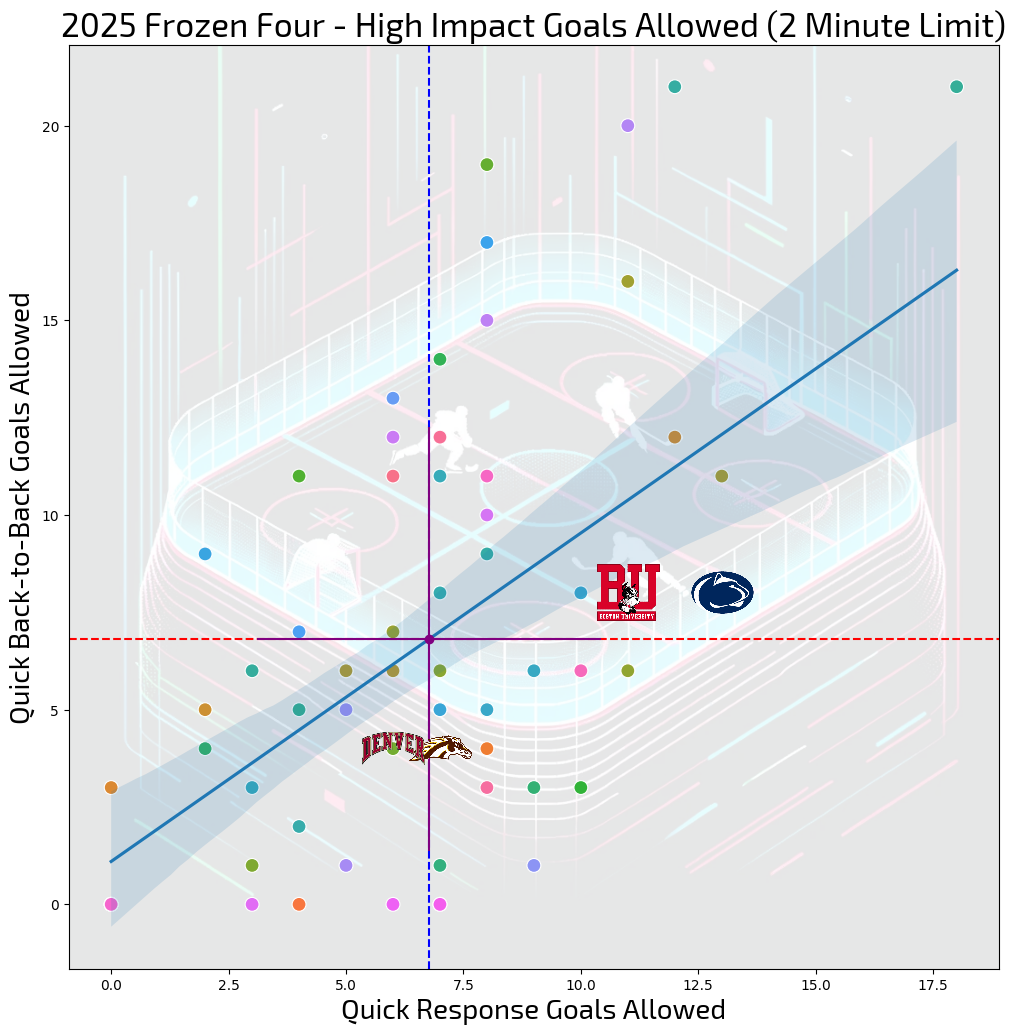

In [84]:
## Call The Function
create_high_impact_plot_2_allowed(group_title, teams_to_plot)